## Sequential Inference with ConvCNPs

In this notebook we will briefly illustrate sequeuntial inference in the small data regime with a trained ConvCNP. Rather than diving into ConvCNP implementation and training, this notebook focusses on highlighting what using a trained model might look like in practice. For more details on implementation and training, see [Implementing and Training ConvCNPs](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp_regression.ipynb). We begin by importing the necessary packages.

In [4]:
import matplotlib.pyplot as plt
import torch
import stheno.torch as stheno
from convcnp.set_conv import ConvCNP
from convcnp.cnp import RegressionANP as ANP
from convcnp.architectures import SimpleConv, UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

In this notebook, we use the smaller architecture for $\rho$, which we name `SimpleConv` and can be found in the [architectures](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/architectures.py) file. Rather than training a model, we will simply load a pre-trained model, the weights for which can be found in the repository. 

So that we have something to compare with, let's also construct and load a pre-trained attentive CNP. This is a variant of CNPs that uses attention on the decoder, and is a powerful cousin of ConvCNP. For more details, see [Attentive Neural Processes](https://arxiv.org/abs/1901.05761). Note that this is a version of that model that only employs the deterministic path (since the ConvCNP is also a conditional model with no latent variable, this is an "apples-to-apples" comparison). Our implementation of the AttnCNP can be found in [convcnp.cnp](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/cnp.py).

In [5]:
%%capture
# Load the ConvCNP.
convcnp = ConvCNP(learn_length_scale=True, points_per_unit=64, architecture=SimpleConv())
convcnp.to(device)
load_dict = torch.load('./saved_models/convcnp-matern/model_best.pth.tar')
convcnp.load_state_dict(load_dict['state_dict'])
convcnp.eval()

# Load the AttnCNP.
anp = ANP(latent_dim=128)
anp.to(device)
load_dict = torch.load('./saved_models/anp-matern/model_best.pth.tar')
anp.load_state_dict(load_dict['state_dict'])
anp.eval()

These models were trained on a Matern-5/2 kernel. To demonstrate how they operate, we will first generate a new task as a single sample from the appropriate kernel.

In [9]:
# Construct GP.
kernel = stheno.Matern52().stretch(0.25)
gp = stheno.GP(kernel)

# Sample function from GP and random permutation of data.
num_points = 200
rand_indices = torch.randperm(num_points)
x_all = torch.linspace(-2., 2., num_points)
y_all = gp(x_all).sample()

The random indices provide a random ordering on the task, which allow us to define consistent context sets. Next, we write a simple function to condition the model, and an oracle GP (by oracle we mean having the correct kernel) on the first $m$ points in the set, according to the random ordering. The function will also handle plotting for us.

In [10]:
def plot_task(context_size, model, name):
    x_context = x_all[rand_indices][:context_size][None, :, None].to(device)
    y_context = y_all[rand_indices][:context_size][None, ...].to(device)

    # Make predictions with model.
    with torch.no_grad():
       y_mean, y_std = model(x_context, y_context, x_all[None, :, None].to(device))

    # Make predictions with oracle GP
    post = gp | (to_numpy(x_context), to_numpy(y_context))
    gp_mean, gp_lower, gp_upper = post(to_numpy(x_all)).marginals()

    # Plot context set.
    plt.scatter(to_numpy(x_context), to_numpy(y_context), label='Context Set', color='black')
    plt.plot(to_numpy(x_all), to_numpy(y_all), '--',  label='Sampled function', color='gray', alpha=0.9)
    
    # Plot GP predictions.
    plt.plot(to_numpy(x_all), gp_mean, color='black', label='Oracle GP')
    plt.plot(to_numpy(x_all), gp_lower, color='black', alpha=0.4)
    plt.plot(to_numpy(x_all), gp_upper, color='black', alpha=0.4)
    
    # Plot model predictions.
    plt.plot(to_numpy(x_all), to_numpy(y_mean), label='%s Output' % name, color='blue')
    plt.fill_between(to_numpy(x_all),
                     to_numpy(y_mean + 2 * y_std),
                     to_numpy(y_mean - 2 * y_std),
                     color='tab:blue', alpha=0.2)
    plt.ylim(-3., 3)
    plt.axis('off')
    plt.legend()

We can use this function to sequentially add observations to the context set. After every observation is added, we perform inference on the extended context set with the ConvCNP and the GP, and plot the resulting predictive functions. This sequential process is visualized below. 

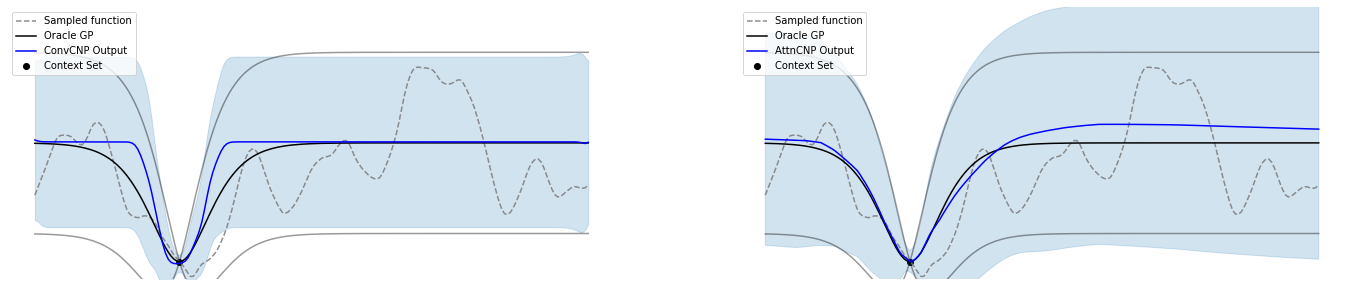

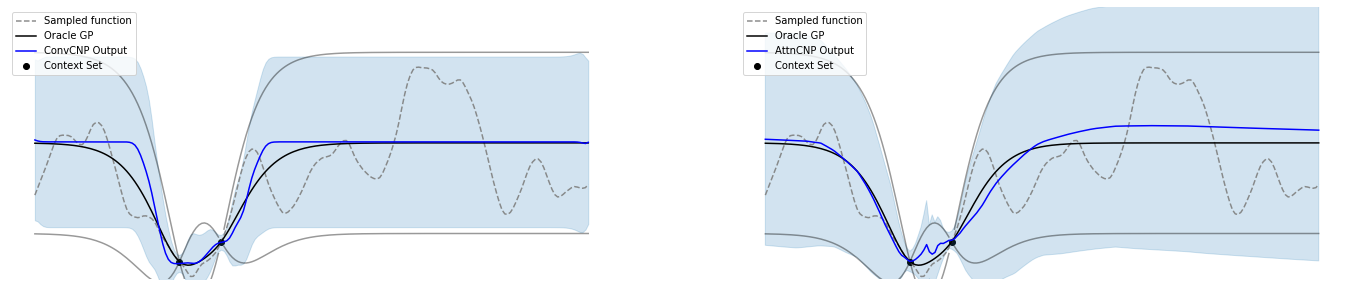

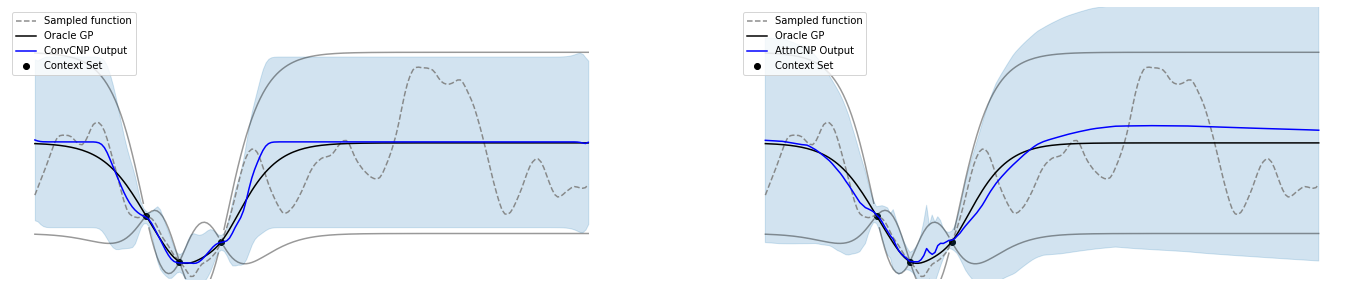

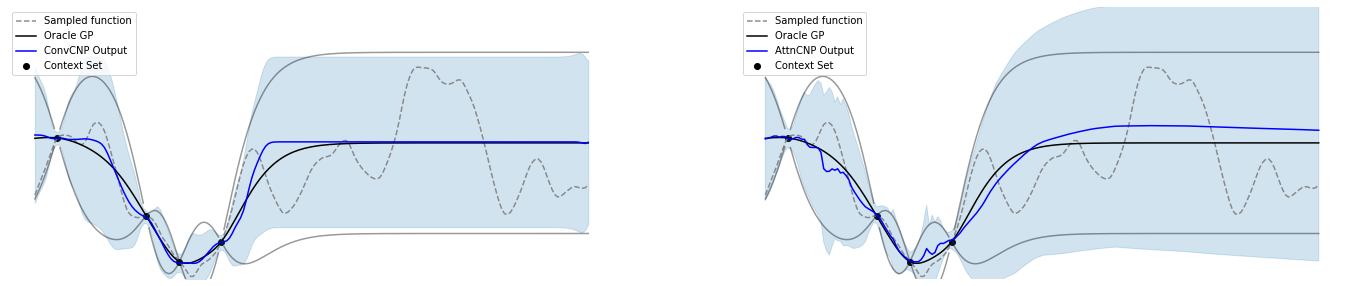

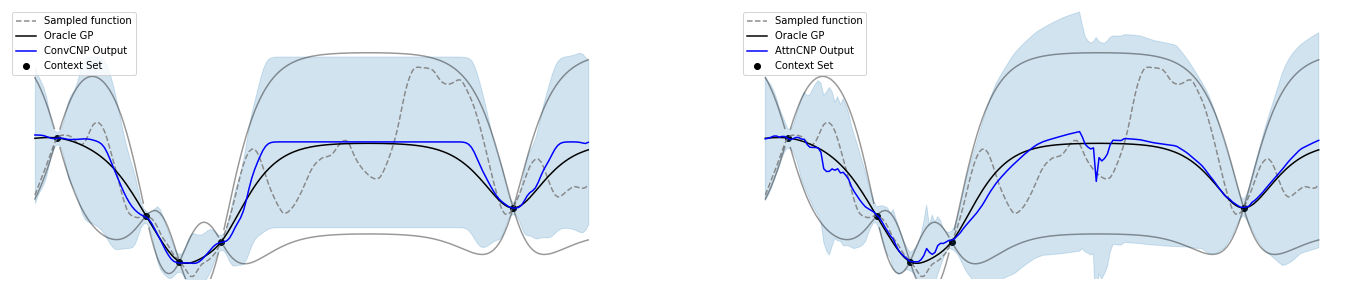

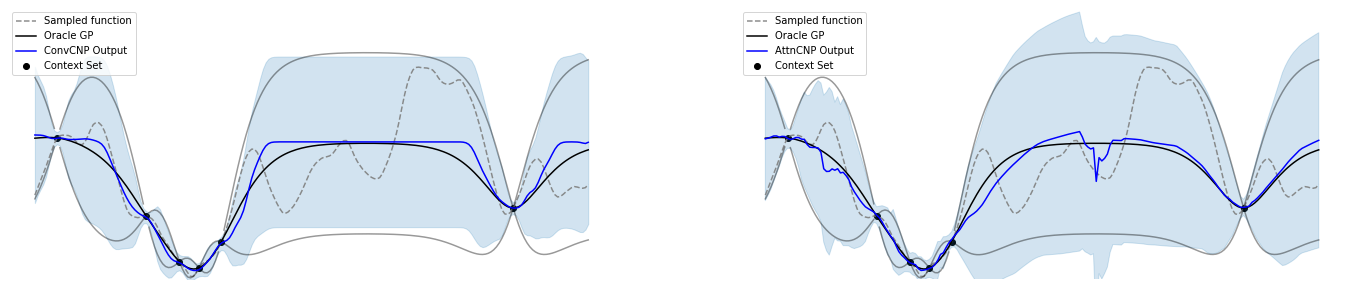

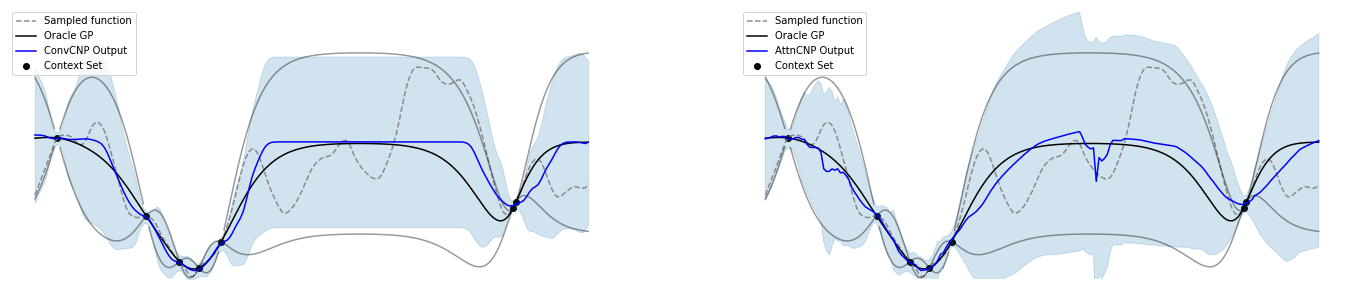

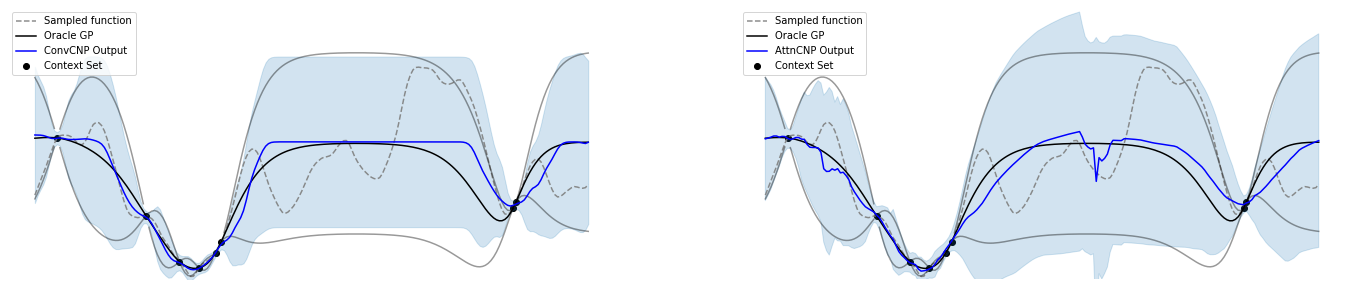

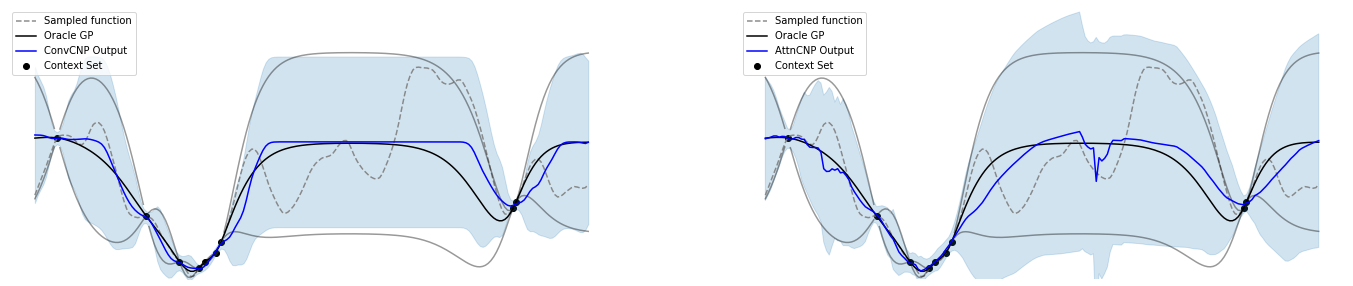

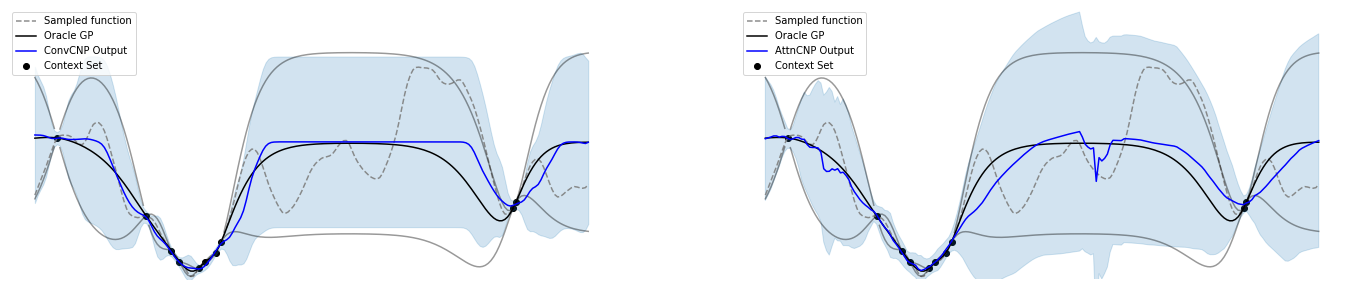

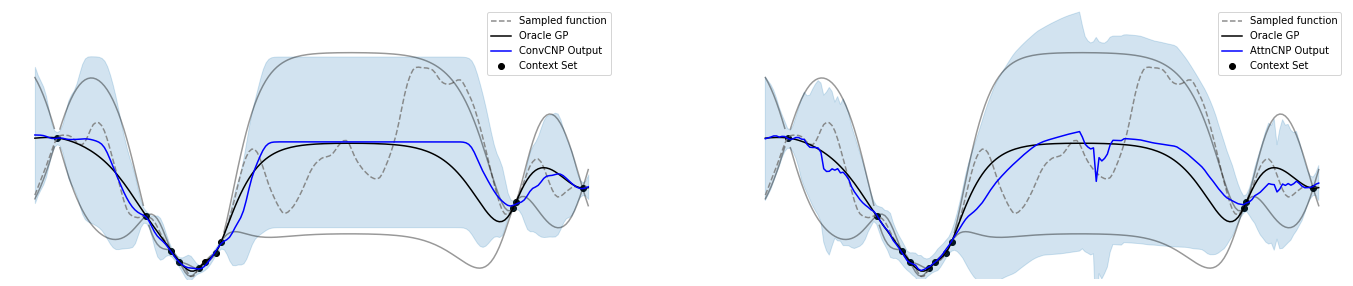

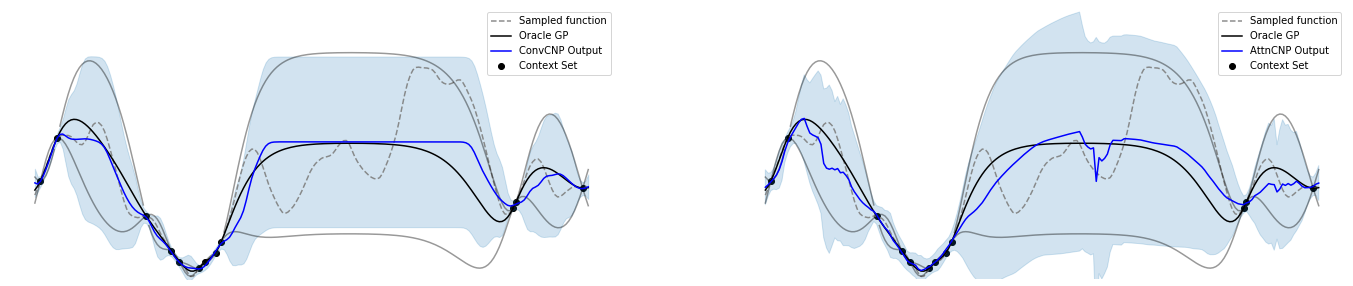

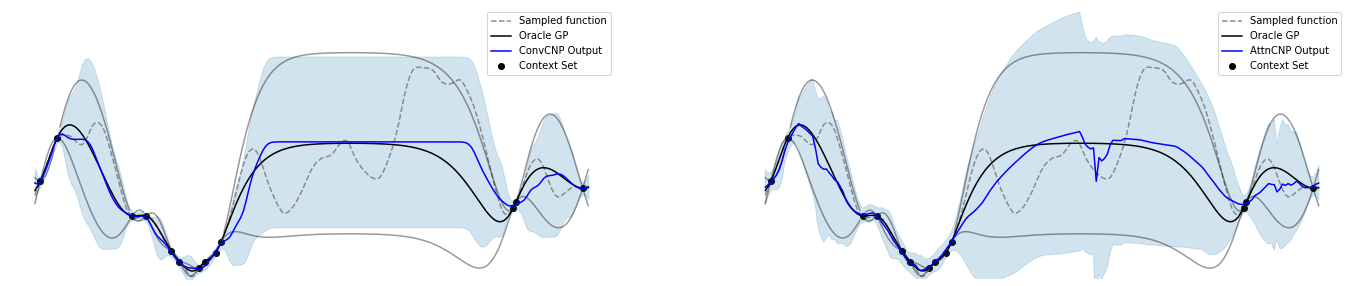

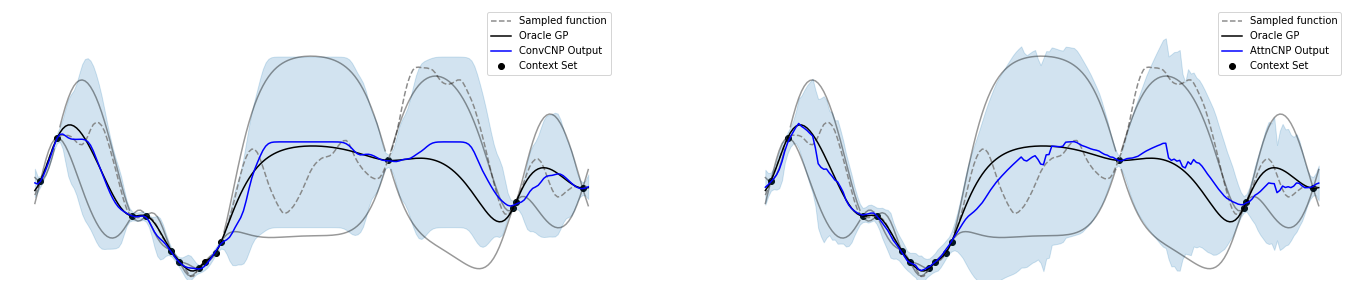

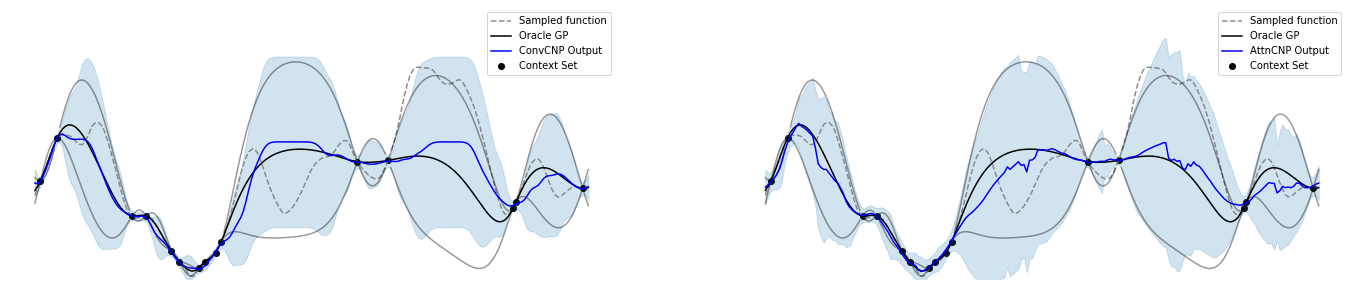

In [11]:
for context_size in range(1, 16):
    fig = plt.figure(figsize=(24, 5))
    plt.subplot(1, 2, 1)
    plot_task(context_size, convcnp, 'ConvCNP')
    plt.subplot(1, 2, 2)
    plot_task(context_size, anp, 'AttnCNP')
    plt.show()

We can see that the ConvCNP provides predictive functions that are close to that of the oracle GP, maintaining higher uncertainty away from the observations, and collapsing the uncertainty where data has been observed. The AttnCNP also does a good job of tracking the predictive posterior. There are some artifacts with the smoothness of the mean and uncertainty functions, but these can largely be fixed by improving the attention mechanisms and employing latent variable models. 

# Out of training range generalization

With this demonstration in place, let us consider generalization with the two models. Recall that during training, the models only encountered data in the range of $[-2, 2]$. First, let us generate data from a larger input range, say $[-5, 5]$. 

In [12]:
# Construct GP.
kernel = stheno.Matern52().stretch(0.25)
gp = stheno.GP(kernel)

# Sample function from GP and random permutation of data.
num_points = 500
rand_indices = torch.randperm(200)
x_all = torch.linspace(-5., 5., num_points)
y_all = gp(x_all).sample()
x_in_dist, y_in_dist = x_all[150:350], y_all[150:350]
x_out_dist, y_out_dist = torch.cat((x_all[:150], x_all[350:])), torch.cat((y_all[:150], y_all[350:]))


We slightly modify the plotting function to show us the boundaries of the training distribution range, as well as handle data from outside the training range.

In [13]:
def plot_out_of_dist_task(context_size, num_out_dist, model, name):
    x_context = x_in_dist[rand_indices][:context_size][None, :, None].to(device)
    y_context = y_in_dist[rand_indices][:context_size][None, ...].to(device)
    
    if num_out_dist > 0:
        additional_xs = x_out_dist[rand_indices][:num_out_dist][None, :, None].to(device)
        additional_ys = y_out_dist[rand_indices][:num_out_dist][None, ...].to(device)
        x_context = torch.cat((x_context, additional_xs), dim=1)
        y_context = torch.cat((y_context, additional_ys), dim=1)
        
    # Make predictions with model.
    with torch.no_grad():
       y_mean, y_std = model(x_context, y_context, x_all[None, :, None].to(device))

    # Make predictions with oracle GP.
    post = gp  | (to_numpy(x_context), to_numpy(y_context))
    gp_mean, gp_lower, gp_upper = post(to_numpy(x_all)).marginals()

    # Plot context set and model predictions.
    plt.scatter(to_numpy(x_context), to_numpy(y_context), label='Context Set', color='black')
    plt.plot(to_numpy(x_all), to_numpy(y_all),  '--', label='Sampled function', color='gray', alpha=0.8)
    
    # Plot GP predictions.
    plt.plot(to_numpy(x_all), gp_mean, color='black', label='Oracle GP')
    plt.plot(to_numpy(x_all), gp_lower, color='black', alpha=0.4)
    plt.plot(to_numpy(x_all), gp_upper, color='black', alpha=0.4)
    
    # Plot model predictions.
    plt.plot(to_numpy(x_all), to_numpy(y_mean), label='%s Output' % name, color='blue')
    plt.fill_between(to_numpy(x_all),
                     to_numpy(y_mean + 2 * y_std),
                     to_numpy(y_mean - 2 * y_std),
                     color='tab:blue', alpha=0.2)
    plt.vlines([-2, 2], -3, 3, linestyles='dashed')
    plt.ylim(-3., 3)
    plt.xlim(-5., 5)
    plt.axis('off')
    plt.legend()

Now, we can start with a context set from the training range, and see what happens as we slowly add points from outside the range observed during training.

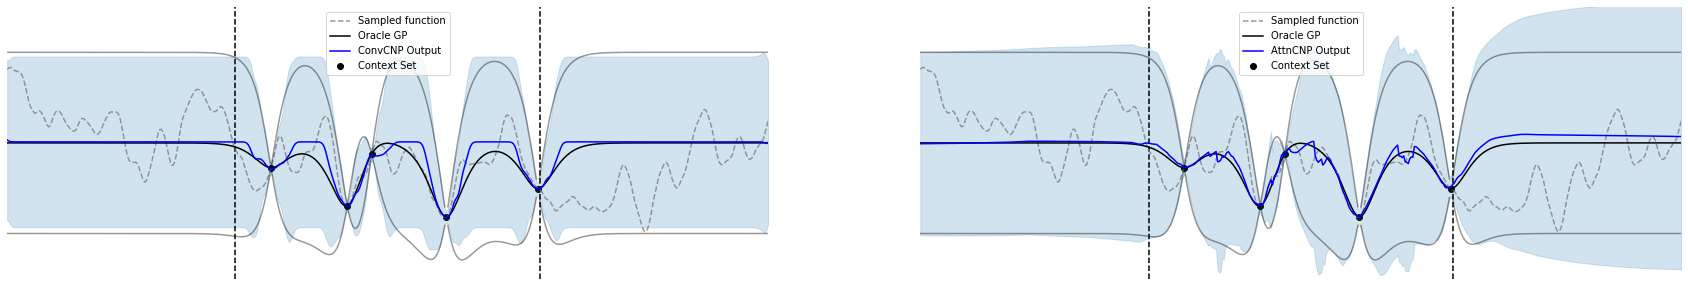

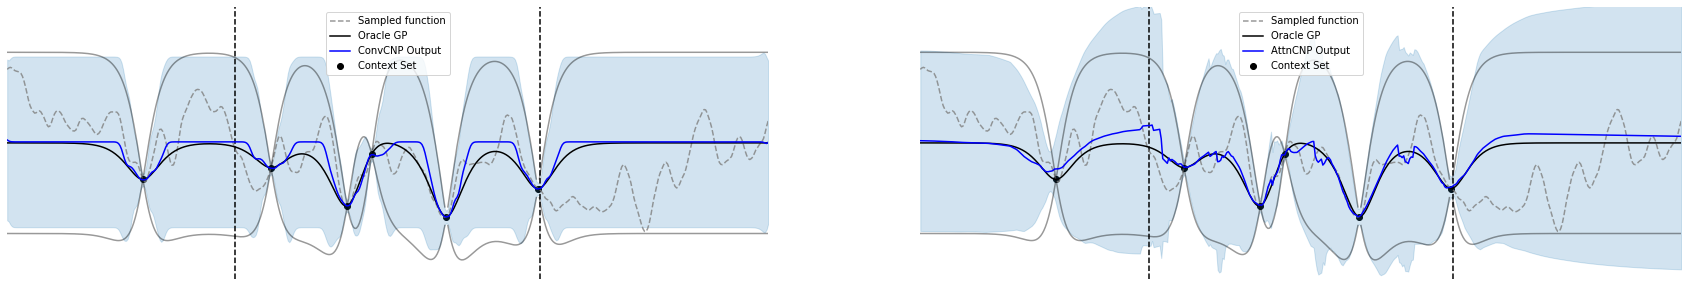

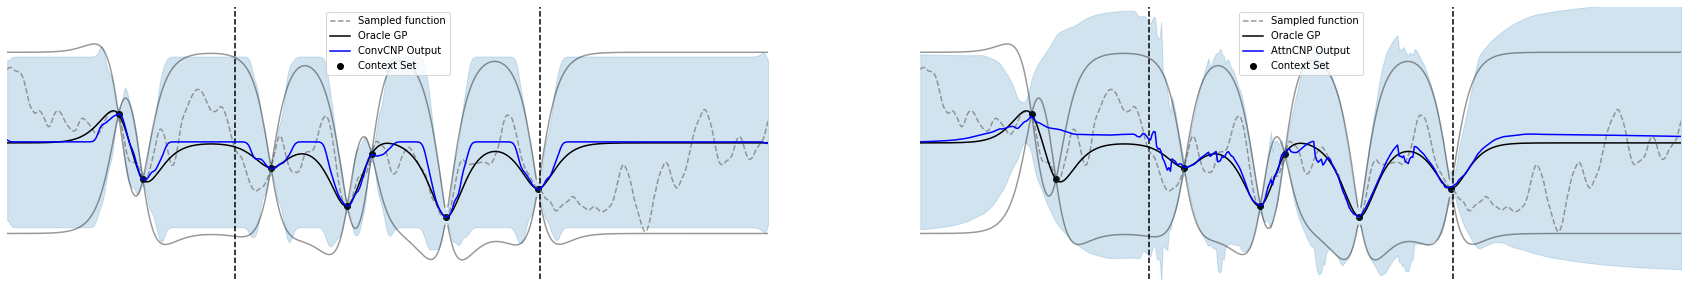

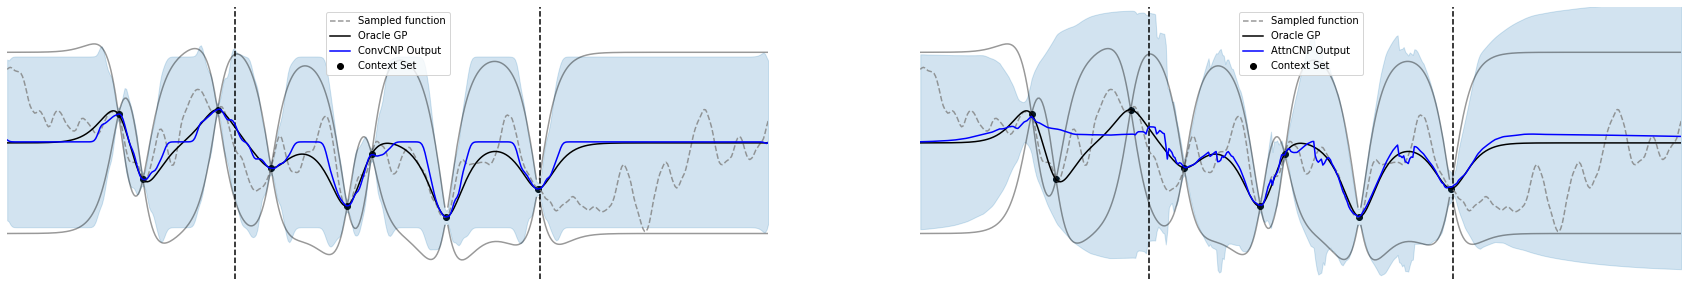

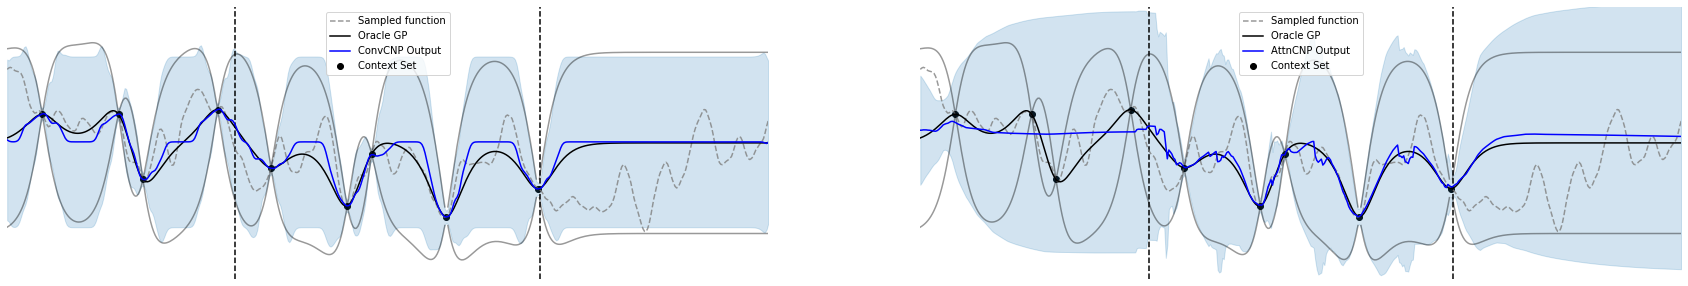

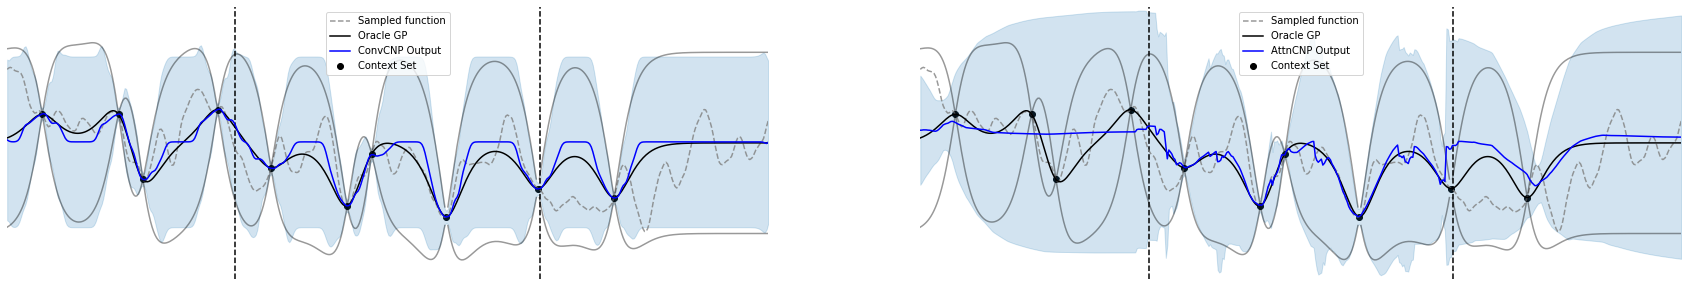

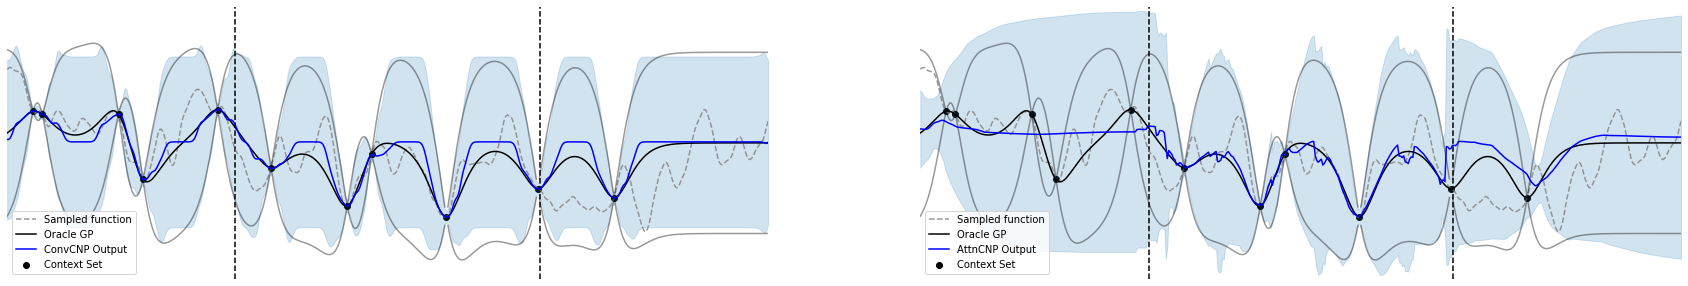

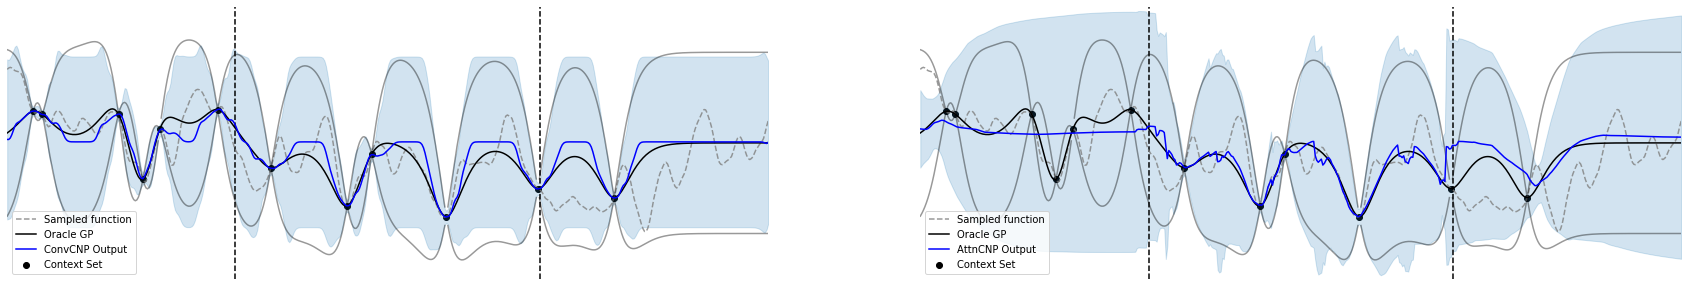

In [14]:
context_size = 5
for out_dist_points in range(0, 8):
    fig = plt.figure(figsize=(30, 5))
    plt.subplot(1, 2, 1)
    plot_out_of_dist_task(context_size, out_dist_points, convcnp, 'ConvCNP')
    plt.subplot(1, 2, 2)
    plot_out_of_dist_task(context_size, out_dist_points, anp, 'AttnCNP')
    plt.show()


Notice that when points are added outside the training range of $[-2, 2]$, the ConvCNP is still able to make reasonable predictions close to the oracle GP. This demonstrates that translation equivariance allows the ConvCNP to perform zero-shot generalisation to out-of-distribution inputs. On the other hand, the AttnCNP fails to correctly interpolate the new points, or to collapse its uncertainty around them. 